### Diagnosis Predictor App
**I create a Diagnosis Predictor App, using Natural Language Processing (NLP), Deep Learning Algorithms (LSTM) and BERT based bioBERT which a fine tuned transformer model for medical data.**

Loading the Necessary Libraries

In [1]:
import nltk
import torch
import gensim
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments

nltk.download("punkt_tab")
nltk.download("stopwords")

# Stopwords list
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, precision_recall_curve,confusion_matrix

 ### Load & Preprocess Clinical Text Data

Load Dataset and Train-Test Split

In [3]:
import pandas as pd

In [4]:
clinical_notes = pd.read_csv("clinical_notes.csv")

In [5]:
clinical_notes.head

<bound method NDFrame.head of                                          Clinical Notes  \
0     A 35-year-old male presents with heartburn, re...   
1     A 55-year-old male with a history of heavy alc...   
2     A 50-year-old male with a history of diabetes ...   
3     A 35-year-old male presents with heartburn, re...   
4     A 55-year-old female with a history of obesity...   
...                                                 ...   
4995  A 55-year-old male with a history of heavy alc...   
4996  A 40-year-old female presents with swelling, p...   
4997  A 55-year-old male with a history of heavy alc...   
4998  A 40-year-old female presents with swelling, p...   
4999  A 70-year-old male with a long history of smok...   

                                  Diagnosis  
0           Gastroesophageal Reflux Disease  
1                           Liver Cirrhosis  
2                              Septic Shock  
3           Gastroesophageal Reflux Disease  
4                  Type 2 Diabetes Mellitus  
...                                     ...  
4995                        Liver Cirrhosis  
4996                   Deep Vein Thrombosis  
4997                        Liver Cirrhosis  
4998                   Deep Vein Thrombosis  
4999  Chronic Obstructive Pulmonary Disease  

[5000 rows x 2 columns]>

In [6]:
clinical_notes.shape

(5000, 2)

### Preprocessing Function

In [7]:
import re
import string

data = clinical_notes

# Extended clean_text function with more steps
def clean_text(text):
    # Convert to string and lowercase the text
    text = str(text).lower()

    # Remove special characters, punctuation, and non-alphabetical characters
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the cleaning function to the Clinical Notes column
data['Clinical Notes'] = data['Clinical Notes'].apply(clean_text)

# Show the cleaned data
data.head()

,Clinical Notes,Diagnosis
0,35yearold male presents heartburn regurgitatio...,Gastroesophageal Reflux Disease
1,55yearold male history heavy alcohol use prese...,Liver Cirrhosis
2,50yearold male history diabetes presents hypot...,Septic Shock
3,35yearold male presents heartburn regurgitatio...,Gastroesophageal Reflux Disease
4,55yearold female history obesity hypertension ...,Type 2 Diabetes Mellitus


In [8]:
data['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


In [9]:
# Label encoding for 'diagnosis' column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

In [10]:
data.head

<bound method NDFrame.head of                                          Clinical Notes  Diagnosis
0     35yearold male presents heartburn regurgitatio...          9
1     55yearold male history heavy alcohol use prese...         11
2     50yearold male history diabetes presents hypot...         16
3     35yearold male presents heartburn regurgitatio...          9
4     55yearold female history obesity hypertension ...         18
...                                                 ...        ...
4995  55yearold male history heavy alcohol use prese...         11
4996  40yearold female presents swelling pain rednes...          8
4997  55yearold male history heavy alcohol use prese...         11
4998  40yearold female presents swelling pain rednes...          8
4999  70yearold male long history smoking presents p...          5

[5000 rows x 2 columns]>

 Split data into train and test

In [11]:
from sklearn.model_selection import train_test_split
# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Clinical Notes'], data['Diagnosis'], test_size=0.2)

In [12]:
test_texts.shape

(1000,)

 ## Tokenization using BERT tokenizer

In [13]:
# Tokenization using BERT tokenizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

###  Implement LSTM/BERT-Based Sequence Tagging for Clinical Text

In [15]:
!pip install datasets


# Convert to Dataset format
from datasets import Dataset

train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.7 MB/s eta 0:00:00


In [16]:
# Load model
model = BertForSequenceClassification.from_pretrained("monologg/biobert_v1.1_pubmed", num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/biobert_v1.1_pubmed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drsyedfaizan1987 (drsyedfaizan1987-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,2.541800,2.357928
2,0.765800,0.568975
3,0.115900,0.069411
4,0.028400,0.019156
5,0.018900,0.012818


TrainOutput(global_step=625, training_loss=0.9455267060041428, metrics={'train_runtime': 304.7928, 'train_samples_per_second': 65.618, 'train_steps_per_second': 2.051, 'total_flos': 770957748000000.0, 'train_loss': 0.9455267060041428, 'epoch': 5.0})

Classification Report:
                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        44
                  Acute Renal Failure       1.00      1.00      1.00        59
                               Asthma       1.00      1.00      1.00        53
             Cerebrovascular Accident       1.00      1.00      1.00        46
               Chronic Kidney Disease       1.00      1.00      1.00        57
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        54
         Community-Acquired Pneumonia       1.00      1.00      1.00        43
             Congestive Heart Failure       1.00      1.00      1.00        53
                 Deep Vein Thrombosis       1.00      1.00      1.00        56
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        37
                         Hypertension       1.00      1.00      1.00        44
                      Liver 

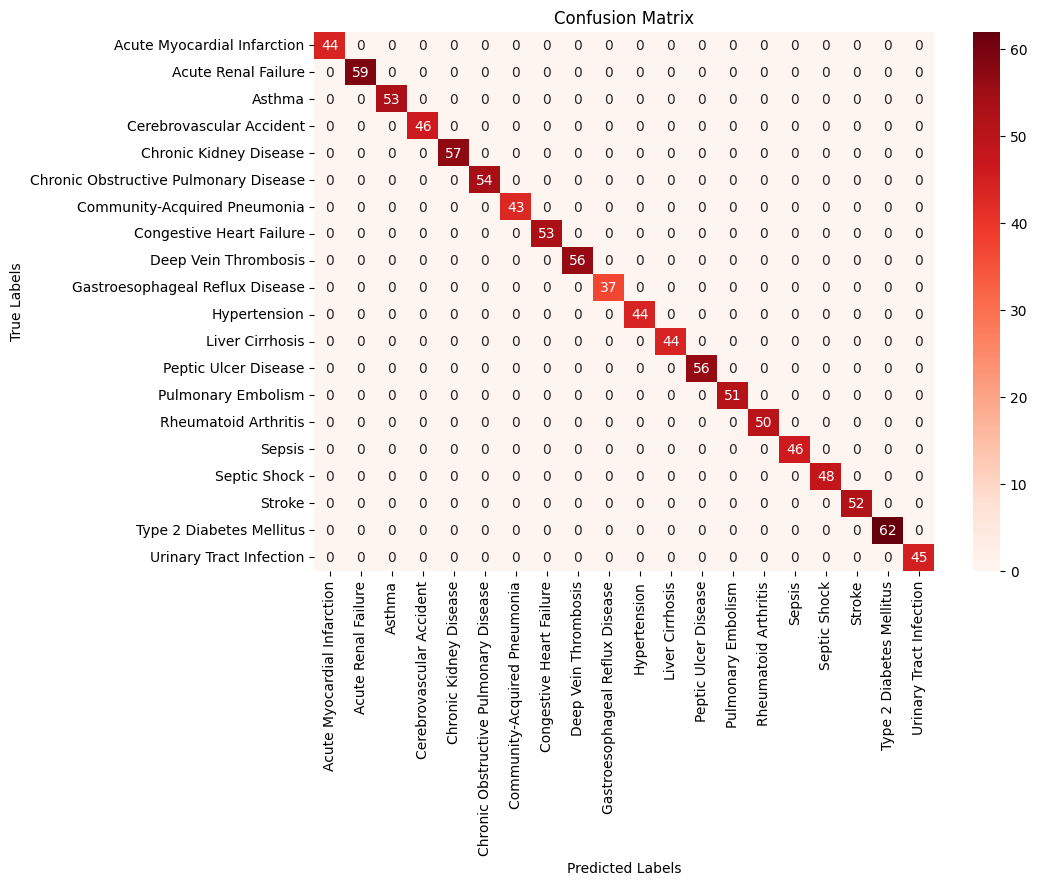

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)


# Make sure the 'label_encoder.classes_' are passed as string labels
target_names = [str(label) for label in label_encoder.classes_]

# Print Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

We now proceed to create the App

In [19]:
# Save the model and tokenizer
trainer.save_model('./patient_model')  # Saves the model
trainer.save_state()  # Saves the training state (e.g., optimizer state, etc.)

tokenizer.save_pretrained('./patient_model')


import pickle
pickle.dump(label_encoder,open("label_encoder.pkl",'wb'))

In [20]:
from transformers import BertForSequenceClassification, BertTokenizer
import pickle

# Load the saved model
model = BertForSequenceClassification.from_pretrained('./patient_model')

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('./patient_model')

# Load the label encoder
with open("label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

In [21]:
import torch

# Function to make prediction
def predict_disease(patient_note, model, tokenizer, label_encoder):

    # Tokenize the input patient note
    inputs = tokenizer(patient_note, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    # Convert the predicted label to the corresponding disease name
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_disease

In [23]:
!pip install fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.6 MB/s eta 0:00:00


In [26]:
!pip install PyPDF2

In [27]:
from fastapi import FastAPI, File, UploadFile, Form
from fastapi.responses import HTMLResponse, JSONResponse
from fastapi.templating import Jinja2Templates
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import PyPDF2
from io import BytesIO
import pickle
from fastapi import Request

In [28]:
# Load the model, tokenizer, and label encoder
model = BertForSequenceClassification.from_pretrained('./patient_model')
tokenizer = BertTokenizer.from_pretrained('./patient_model')
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [29]:
# FastAPI instance
app = FastAPI()

In [30]:
# Set up templates and static file directory
templates = Jinja2Templates(directory="templates")

In [31]:
# Disease data
disease_data = {
    "Peptic Ulcer Disease": {
        "description": "A sore that develops on the lining of the esophagus, stomach, or small intestine.",
        "medicines": ["Omeprazole", "Pantoprazole", "Ranitidine", "Esomeprazole", "Amoxicillin"],
        "specialists": ["Gastroenterologist", "General Physician", "Internal Medicine Specialist"]
    },
    "Type 2 Diabetes Mellitus": {
        "description": "A chronic condition that affects the way the body processes blood sugar (glucose).",
        "medicines": ["Metformin", "Glipizide", "Insulin", "Sitagliptin", "Canagliflozin"],
        "specialists": ["Endocrinologist", "Diabetologist", "Nutritionist"]
    },
    "Acute Myocardial Infarction": {
        "description": "A medical emergency where the blood flow to the heart is blocked.",
        "medicines": ["Aspirin", "Clopidogrel", "Statins", "Beta Blockers", "ACE Inhibitors"],
        "specialists": ["Cardiologist", "Emergency Medicine Specialist"]
    },
    "Chronic Obstructive Pulmonary Disease": {
        "description": "A group of lung diseases that block airflow and make breathing difficult.",
        "medicines": ["Tiotropium", "Albuterol", "Ipratropium", "Fluticasone", "Salmeterol"],
        "specialists": ["Pulmonologist", "General Physician", "Respiratory Therapist"]
    },
    "Cerebrovascular Accident (Stroke)": {
        "description": "A condition caused by the interruption of blood flow to the brain.",
        "medicines": ["Alteplase", "Aspirin", "Clopidogrel", "Warfarin", "Atorvastatin"],
        "specialists": ["Neurologist", "Rehabilitation Specialist", "Neurosurgeon"]
    },
    "Deep Vein Thrombosis": {
        "description": "A blood clot forms in a deep vein, usually in the legs.",
        "medicines": ["Warfarin", "Heparin", "Apixaban", "Dabigatran", "Rivaroxaban"],
        "specialists": ["Hematologist", "Vascular Surgeon", "Cardiologist"]
    },
    "Chronic Kidney Disease": {
        "description": "The gradual loss of kidney function over time.",
        "medicines": ["Erythropoietin", "Phosphate Binders", "ACE Inhibitors", "Diuretics", "Calcitriol"],
        "specialists": ["Nephrologist", "Dietitian", "Internal Medicine Specialist"]
    },
    "Community-Acquired Pneumonia": {
        "description": "A lung infection acquired outside of a hospital setting.",
        "medicines": ["Amoxicillin", "Azithromycin", "Clarithromycin", "Ceftriaxone", "Levofloxacin"],
        "specialists": ["Pulmonologist", "Infectious Disease Specialist", "General Physician"]
    },
    "Septic Shock": {
        "description": "A severe infection leading to dangerously low blood pressure.",
        "medicines": ["Norepinephrine", "Vancomycin", "Meropenem", "Hydrocortisone", "Dopamine"],
        "specialists": ["Intensivist", "Infectious Disease Specialist", "Emergency Medicine Specialist"]
    },
    "Rheumatoid Arthritis": {
        "description": "An autoimmune disorder causing inflammation in joints.",
        "medicines": ["Methotrexate", "Sulfasalazine", "Hydroxychloroquine", "Adalimumab", "Etanercept"],
        "specialists": ["Rheumatologist", "Orthopedic Specialist", "Physical Therapist"]
    },
    "Congestive Heart Failure": {
        "description": "A chronic condition where the heart doesn't pump blood effectively.",
        "medicines": ["ACE Inhibitors", "Beta Blockers", "Diuretics", "Spironolactone", "Digoxin"],
        "specialists": ["Cardiologist", "General Physician", "Cardiac Surgeon"]
    },
    "Pulmonary Embolism": {
        "description": "A blockage in one of the pulmonary arteries in the lungs.",
        "medicines": ["Heparin", "Warfarin", "Alteplase", "Rivaroxaban", "Dabigatran"],
        "specialists": ["Pulmonologist", "Hematologist", "Emergency Medicine Specialist"]
    },
    "Sepsis": {
        "description": "A life-threatening organ dysfunction caused by a dysregulated immune response to infection.",
        "medicines": ["Vancomycin", "Meropenem", "Piperacillin-Tazobactam", "Cefepime", "Dopamine"],
        "specialists": ["Infectious Disease Specialist", "Intensivist", "Emergency Medicine Specialist"]
    },
    "Liver Cirrhosis": {
        "description": "A late-stage liver disease caused by liver scarring and damage.",
        "medicines": ["Spironolactone", "Furosemide", "Lactulose", "Nadolol", "Rifaximin"],
        "specialists": ["Hepatologist", "Gastroenterologist", "Nutritionist"]
    },
    "Acute Renal Failure": {
        "description": "A sudden loss of kidney function.",
        "medicines": ["Diuretics", "Dopamine", "Calcium Gluconate", "Sodium Bicarbonate", "Epoetin"],
        "specialists": ["Nephrologist", "Critical Care Specialist", "Internal Medicine Specialist"]
    },
    "Urinary Tract Infection": {
        "description": "An infection in any part of the urinary system.",
        "medicines": ["Nitrofurantoin", "Ciprofloxacin", "Amoxicillin-Clavulanate", "Trimethoprim-Sulfamethoxazole", "Cephalexin"],
        "specialists": ["Urologist", "General Physician", "Infectious Disease Specialist"]
    },
    "Hypertension": {
        "description": "A condition in which the force of the blood against the artery walls is too high.",
        "medicines": ["Lisinopril", "Amlodipine", "Losartan", "Hydrochlorothiazide", "Metoprolol"],
        "specialists": ["Cardiologist", "General Physician", "Nephrologist"]
    },
    "Asthma": {
        "description": "A condition in which the airways narrow and swell, causing difficulty in breathing.",
        "medicines": ["Albuterol", "Fluticasone", "Montelukast", "Budesonide", "Salmeterol"],
        "specialists": ["Pulmonologist", "Allergist", "General Physician"]
    },
    "Gastroesophageal Reflux Disease (GERD)": {
        "description": "A digestive disorder where stomach acid irritates the esophagus.",
        "medicines": ["Omeprazole", "Esomeprazole", "Ranitidine", "Lansoprazole", "Pantoprazole"],
        "specialists": ["Gastroenterologist", "General Physician", "Dietitian"]
    }
}


In [32]:
# Route for rendering the index page
@app.get("/", response_class=HTMLResponse)
async def upload_form(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

In [33]:
# Function to get disease details
def get_disease_details(disease_name):
    if disease_name in disease_data:
        return disease_data[disease_name]
    return {
        "description": "No details available for this disease.",
        "medicines": [],
        "specialists": []
    }

In [35]:
!pip install python-multipart


In [36]:
# Updated predict endpoint
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    content = await file.read()
    text = ""

    # Extract text from PDF or TXT file
    if file.filename.endswith(".pdf"):
        pdf_reader = PyPDF2.PdfReader(BytesIO(content))
        for page in pdf_reader.pages:
            text += page.extract_text()
    elif file.filename.endswith(".txt"):
        text = content.decode("utf-8")

    # Predict disease
    predicted_disease = predict_disease(text, model, tokenizer, label_encoder)
    disease_details = get_disease_details(predicted_disease)

    # Return result
    return JSONResponse(content={
        "predicted_disease": predicted_disease,
        "description": disease_details["description"],
        "medicines": disease_details["medicines"],
        "specialists": disease_details["specialists"]
    })



In [37]:
!pip install nest_asyncio pyngrok

In [39]:
!pip install fastapi uvicorn jinja2 python-multipart PyPDF2 pydantic nest_asyncio pyngrok


In [40]:
from fastapi import FastAPI, File, UploadFile, Request
from fastapi.responses import HTMLResponse, JSONResponse
from fastapi.templating import Jinja2Templates
import PyPDF2
from io import BytesIO
import nest_asyncio
from pyngrok import ngrok
import uvicorn

In [41]:
# Enable nested asyncio (only needed in Jupyter/Colab)
nest_asyncio.apply()

# Expose FastAPI via ngrok if running in Google Colab
public_url = ngrok.connect(8000).public_url
print(f"Public URL: {public_url}")

# Run Uvicorn server
uvicorn.run(app, host="0.0.0.0", port=8000)

ERROR:pyngrok.process.ngrok:t=2025-02-16T12:08:19+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-02-16T12:08:19+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-02-16T12:08:19+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.